## Prep to run this notebook:
- python scripts/run_vk_ref_geuvadis.py
- python scripts/run_vk_count_geuvadis.py
- python scripts/run_vk_count_geuvadis_wxs.py

In [1]:
# try:
#     import varseek as vk
# except ImportError:
#     print("varseek not found, installing...")
#     !pip install -U -q varseek
# try:
#     import RLSRWP_2025
# except ImportError:
#     print("RLSRWP_2025 not found, installing...")
#     !pip install -q git+https://github.com/pachterlab/RLSRWP_2025.git

In [2]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import seaborn as sns
import re
import anndata as ad
from scipy import sparse
import scanpy as sc

import varseek as vk
from RLSRWP_2025.constants import box_links_dict

RLSRWP_2025_dir = os.path.dirname(os.path.abspath(""))  # if this notebook resides in RLSRWP_2025/notebooks/0_data_download.ipynb, then this retrieves RLSRWP_2025
data_dir = os.path.join(RLSRWP_2025_dir, "data")

In [3]:
sequencing_data_out_base = os.path.join(data_dir, "geuvadis_data_base")
geuvadis_reference_files_dir = os.path.join(data_dir, "reference", "geuvadis")
variants_transcriptome_df_path = os.path.join(geuvadis_reference_files_dir, "variants_transcriptome.parquet")
reference_genome_t2g = os.path.join(data_dir, "reference", "ensembl_grch37_release113", "t2g.txt")

geuvadis_genotype_true_adata = os.path.join(geuvadis_reference_files_dir, "genotypes_adata_true.h5ad")
adata_combined_path_reference_genome = os.path.join(sequencing_data_out_base, "adata_reference_genome_combined.h5ad")
adata_combined_path_vcrs_final = os.path.join(sequencing_data_out_base, f"adata_vcrs_combined_w37_k41.h5ad")

reference_dir = os.path.join(RLSRWP_2025_dir, "data", "reference")
t2g_file = os.path.join(reference_dir, "ensembl_grch37_release113", "t2g.txt")

min_counts = 2
min_samples_per_variant = 3
n_top_variants = 2000
gene_set_to_exclude = {'ENSG00000111640', 'ENSG00000242580', 'ENSG00000243466', 'ENST00000603632', 'ENST00000605760'}  # None, or a set of gene names to exclude from the analysis (in ENSGs)

out_dir = os.path.join(data_dir, f"geuvadis_analysis_total")

In [4]:
if not os.path.isfile(adata_combined_path_reference_genome):
    vk.utils.download_box_url(box_links_dict["geuvadis_adata_reference_genome"], output_file_name=adata_combined_path_reference_genome)
if not os.path.isfile(geuvadis_genotype_true_adata):
    vk.utils.download_box_url(box_links_dict["geuvadis_adata_genotype"], output_file_name=geuvadis_genotype_true_adata)
if not os.path.isfile(adata_combined_path_vcrs_final):
    vk.utils.download_box_url(box_links_dict[f"geuvadis_adata_vcrs_w37_k41"], output_file_name=adata_combined_path_vcrs_final)

adata_reference = ad.read_h5ad(adata_combined_path_reference_genome)
adata_genotype = ad.read_h5ad(geuvadis_genotype_true_adata)
adata_vcrs = ad.read_h5ad(adata_combined_path_vcrs_final)

os.makedirs(out_dir, exist_ok=True)

In [5]:
adata_vcrs

AnnData object with n_obs × n_vars = 660 × 178549
    obs: 'experiment_alias_underscores_only', 'experiment_accession', 'library_strategy', 'sample_title', 'Sex', 'Biosample ID', 'Population name', 'Superpopulation name'

In [6]:
adata_reference

AnnData object with n_obs × n_vars = 660 × 57905
    obs: 'experiment_alias_underscores_only', 'experiment_accession', 'library_strategy', 'sample_title', 'Sex', 'Biosample ID', 'Population name', 'Superpopulation name'

In [7]:
adata_genotype

AnnData object with n_obs × n_vars = 1092 × 203850
    var: 'has_id', 'ID', 'variant_header'

## Which samples were excluded due to faulty FASTQs?

In [8]:
# 1. Get all child directory names
all_dirs = [
    name for name in os.listdir(sequencing_data_out_base)
    if os.path.isdir(os.path.join(sequencing_data_out_base, name)) and name.startswith("E_GEUV_1")
]

# 2. Get the list of experiment aliases from AnnData
aliases_in_adata = set(adata_vcrs.obs['experiment_alias_underscores_only'].unique())

# 3. Get directories not listed in adata
unmatched_dirs = [d for d in all_dirs if d not in aliases_in_adata]
unmatched_dirs

['E_GEUV_1_NA20527_1_M_111124_6',
 'E_GEUV_1_NA19114_1_M_120209_8',
 'E_GEUV_1_NA11992_1_M_120209_6',
 'E_GEUV_1_HG00117_1_M_120209_1',
 'E_GEUV_1_NA07346_1_M_120209_4',
 'E_GEUV_1_HG00237_4_M_120208_1',
 'E_GEUV_1_NA12156_1_M_120209_7']

## PP

#### Drop duplicates from adata_vcrs

In [9]:
# adata_vcrs = adata_vcrs[~adata_vcrs.obs['sample_title'].duplicated(keep='first')].copy()

In [10]:
print(adata_vcrs.obs['Superpopulation name'].value_counts())
adata_vcrs.obs['Superpopulation name'] = adata_vcrs.obs['Superpopulation name'].replace(
    'European Ancestry,West Eurasia (SGDP)', 'European Ancestry'
)

print(adata_vcrs.obs['Population name'].value_counts())
adata_vcrs.obs['Population name'] = adata_vcrs.obs['Population name'].replace({
    'British,English': 'British',
    'Finnish,Finnish': 'Finnish'
})

Superpopulation name
European Ancestry                        494
African Ancestry                         162
European Ancestry,West Eurasia (SGDP)      4
Name: count, dtype: int64
Population name
Yoruba             162
CEPH               159
Finnish            112
Toscani            112
British            111
British,English      2
Finnish,Finnish      2
Name: count, dtype: int64


In [11]:
if not os.path.isfile(variants_transcriptome_df_path):
    vk.utils.download_box_url(box_links_dict["geuvadis_variants"], output_file_name=variants_transcriptome_df_path)

variants_transcriptome_df = pd.read_parquet(variants_transcriptome_df_path)
variants_transcriptome_df['variant_header_cdna'] = variants_transcriptome_df['transcript_ID'] + ":" + variants_transcriptome_df['variant_cdna']
adata_genotype.obs['sample_title'] = adata_genotype.obs.index.astype(str).str.slice(2)
adata_genotype.var = adata_genotype.var.merge(variants_transcriptome_df[["variant_header", "variant_header_cdna"]], how="left", on="variant_header")
adata_genotype.var.rename(columns={"variant_header": "variant_header_cds", "variant_header_cdna": "variant_header"}, inplace=True)
adata_genotype.obs = adata_genotype.obs.merge(adata_vcrs.obs[['sample_title', 'Sex', 'Population name', 'Superpopulation name']].drop_duplicates(subset='sample_title'), on='sample_title', how='left')
adata_genotype.var.index = adata_genotype.var.index.astype(str)  # otherwise I get AssertionError: Don’t call _normalize_index with non-categorical/string names
adata_genotype.obs.index = adata_genotype.obs.index.astype(str)

adata_reference.var['gene'] = adata_reference.var.index.str.split(".").str[0]
t2g_dict = vk.utils.make_t2g_dict(t2g_file, strip_versions=True)

/home/jmrich/Desktop/varseek/varseek/utils/varseek_clean_utils.py:2276: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  t2g_df = pd.read_csv(t2g_file, sep="\t", header=None)


In [12]:
adata_vcrs = adata_vcrs[:, ~adata_vcrs.var_names.str.contains(";")]   # Remove columns (variants) with semicolon in name

if "transcript_ID" not in adata_vcrs.var.columns:
    adata_vcrs.var['transcript_ID'] = [idx.split(':')[0] for idx in adata_vcrs.var_names]

if "gene_id" not in adata_vcrs.var.columns:
    adata_vcrs.var["gene_id"] = adata_vcrs.var["transcript_ID"].map(t2g_dict).fillna(adata_vcrs.var["transcript_ID"])

if min_counts is not None:
    adata_vcrs.X = adata_vcrs.X.multiply(adata_vcrs.X >= min_counts)

if "variant_count" not in adata_vcrs.var.columns:
    adata_vcrs.var["variant_count"] = adata_vcrs.X.sum(axis=0).A1 if hasattr(adata_vcrs.X, "A1") else np.asarray(adata_vcrs.X.sum(axis=0)).flatten()

### Ensure adata_genotype is aligned with adata_vcrs

In [13]:
# # 1. Get variant headers from genotype
# variant_headers = adata_genotype.var['variant_header'].values
# header_set = set(variant_headers)

# # 2. Ensure all vcrs variants are present in genotype
# missing = [v for v in adata_vcrs.var.index if v not in header_set]
# if missing:
#     print(f"{len(missing)} variants in adata_vcrs.var.index were not found in adata_genotype.var['variant_header'] and will be removed.")
#     adata_vcrs = adata_vcrs[:, ~adata_vcrs.var.index.isin(missing)].copy()

# # 3. Find indices in the correct order
# variant_to_col = {v: i for i, v in enumerate(variant_headers)}
# cols_to_keep = [variant_to_col[v] for v in adata_vcrs.var.index]

# # 4. Subset adata_genotype to match the order
# adata_genotype = adata_genotype[:, cols_to_keep].copy()

# if "transcript_ID" not in adata_genotype.var.columns:
#     adata_genotype.var['transcript_ID'] = [header.split(':')[0] for header in adata_genotype.var['variant_header']]

# if "gene_id" not in adata_genotype.var.columns:
#     adata_genotype.var["gene_id"] = adata_genotype.var["transcript_ID"].map(t2g_dict).fillna(adata_genotype.var["transcript_ID"])

# keep only overlapping obs
vcrs_titles = set(adata_vcrs.obs['sample_title'])
genotype_titles = set(adata_genotype.obs['sample_title'])

missing = vcrs_titles - genotype_titles
if missing:
    print(f"{len(missing)} samples in adata_vcrs.obs['sample_title'] were not found in adata_genotype.obs['sample_title'].")

adata_genotype = adata_genotype[adata_genotype.obs['sample_title'].isin(adata_vcrs.obs['sample_title'])].copy()

41 samples in adata_vcrs.obs['sample_title'] were not found in adata_genotype.obs['sample_title'].


In [14]:
if gene_set_to_exclude is not None:
    adata_vcrs = adata_vcrs[:, ~adata_vcrs.var['transcript_ID'].isin(gene_set_to_exclude).values]
    adata_vcrs = adata_vcrs[:, ~adata_vcrs.var['gene_id'].isin(gene_set_to_exclude).values]
    # adata_genotype = adata_genotype[:, ~adata_genotype.var['transcript_ID'].isin(gene_set_to_exclude).values]
    # adata_genotype = adata_genotype[:, ~adata_genotype.var['gene_id'].isin(gene_set_to_exclude).values]

In [15]:
adata_vcrs_without_CEPH = adata_vcrs[adata_vcrs.obs['Population name'] != 'CEPH'].copy()
adata_vcrs_without_African = adata_vcrs[adata_vcrs.obs['Superpopulation name'] != 'African Ancestry'].copy()

## Each sample is a "cell", and each variant is a "gene"

In [34]:
def plot_pca(adata, min_samples_per_variant=3, log_adata=False, n_top_variants=n_top_variants, batch_key=None, do_scaling=False, mean_scaling=False, n_pcs=50, size=12, remove_outliers=False, use_binary_matrix=False):
    adata = adata.copy()
    adata_original = adata.copy()
    if use_binary_matrix:
        adata.X = (adata.X > 0).astype(int)
        print("Binary matrix means do not log1p or scale")
        log_adata = False
        if do_scaling:
            mean_scaling = True
        do_scaling = False
    if do_scaling and mean_scaling:
        print("Mean scaling and scaling are mutually exclusive, setting mean_scaling to False")
        mean_scaling = False
    sc.pp.filter_genes(adata, min_cells=min_samples_per_variant)
    if log_adata:
        sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=n_top_variants, batch_key=batch_key)  # batch_key="Population name"
    if do_scaling:
        adata.raw = adata.copy()
        sc.pp.scale(adata, max_value=None)
    if mean_scaling:
        if sparse.issparse(adata.X):
            means = np.array(adata.X.mean(axis=0)).ravel()
            adata.X = adata.X - means  # sparse broadcast
        else:
            adata.X = adata.X - adata.X.mean(axis=0)

    sc.tl.pca(adata)
    if remove_outliers:  # removes outlier greater than 5 standard deviations from the mean in PC1
        pc1 = adata.obsm['X_pca'][:, 0]
        z_scores = np.abs((pc1 - pc1.mean()) / pc1.std())
        threshold = 5
        keep_cells = z_scores <= threshold
        adata = adata_original[keep_cells].copy()
        plot_pca(adata=adata, min_samples_per_variant=min_samples_per_variant, log_adata=log_adata, n_top_variants=n_top_variants, batch_key=batch_key, do_scaling=do_scaling, mean_scaling=mean_scaling, n_pcs=n_pcs, size=size, remove_outliers=False, use_binary_matrix=use_binary_matrix)
        return
    sc.pl.pca_variance_ratio(adata, n_pcs=n_pcs, log=True)
    sc.pl.pca(
        adata,
        color=["Superpopulation name"],
        dimensions=[(0, 1)],
        size=size,
    )

    sc.pl.pca(
        adata,
        color=["Population name"],
        dimensions=[(0, 1)],
        size=size,
    )

    sc.pl.pca(
        adata,
        color=["Sex"],
        dimensions=[(0, 1)],
        size=size,
    )

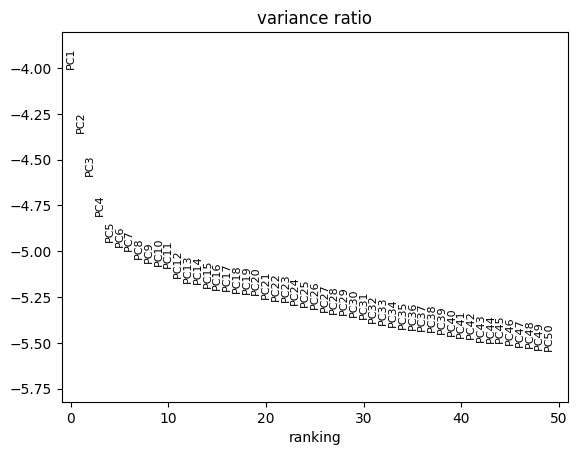

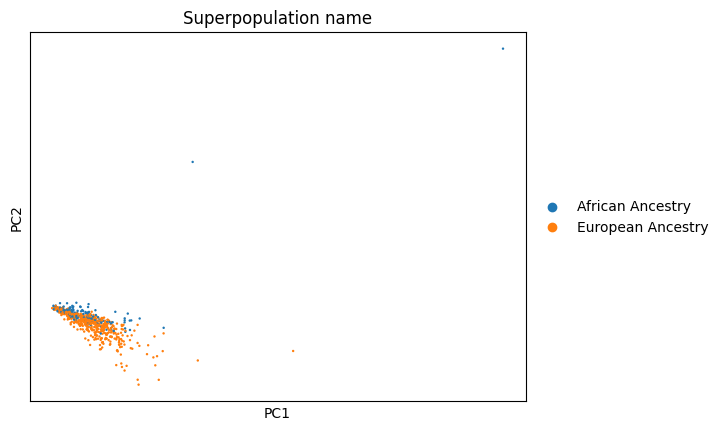

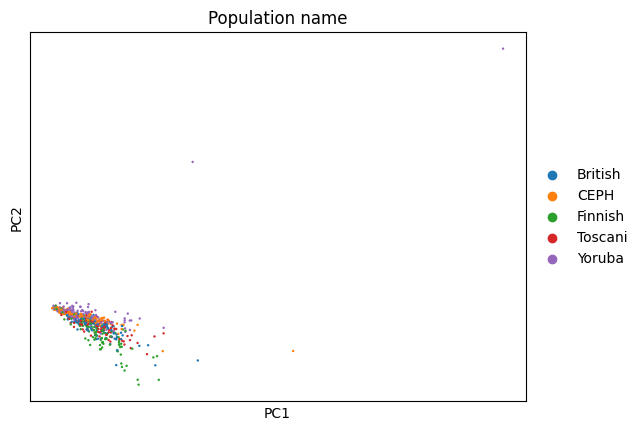

In [17]:
plot_pca(adata_vcrs, min_samples_per_variant=min_samples_per_variant, log_adata=True, n_top_variants=n_top_variants, batch_key=None, do_scaling=True, n_pcs=50, size=12, remove_outliers=False, use_binary_matrix=False)

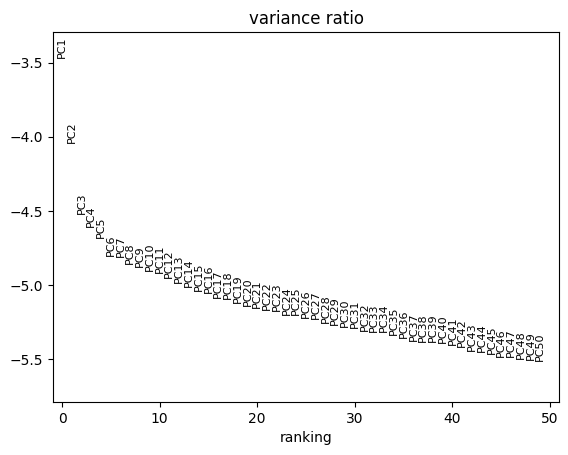

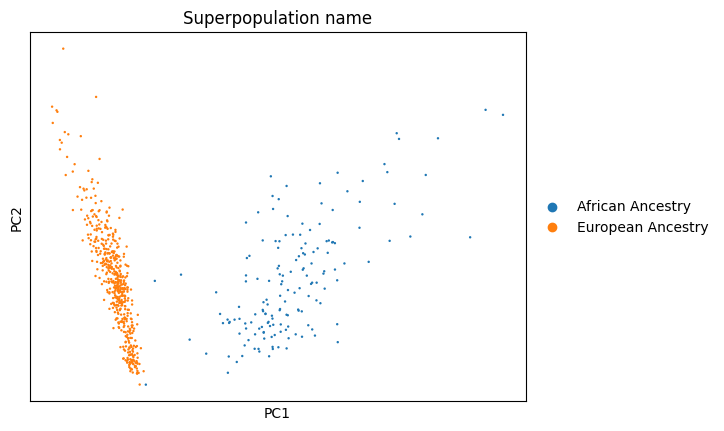

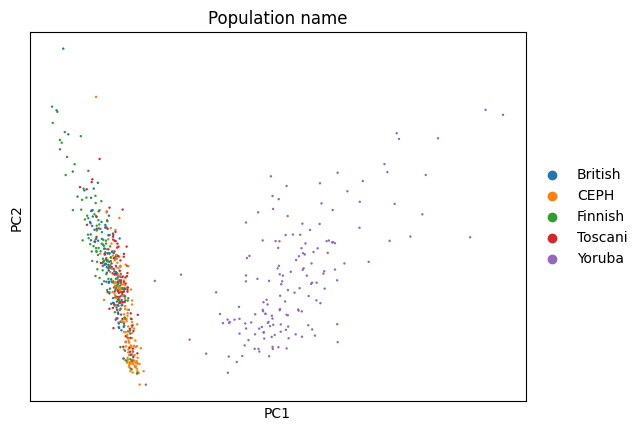

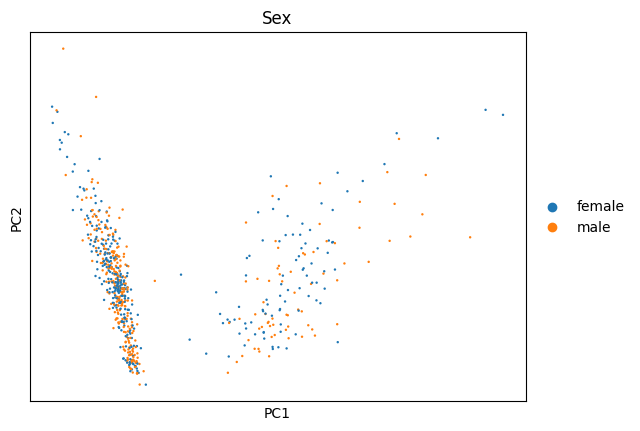

In [ ]:
plot_pca(adata_vcrs, min_samples_per_variant=min_samples_per_variant, log_adata=True, n_top_variants=n_top_variants, batch_key=None, do_scaling=True, n_pcs=50, size=12, remove_outliers=True)

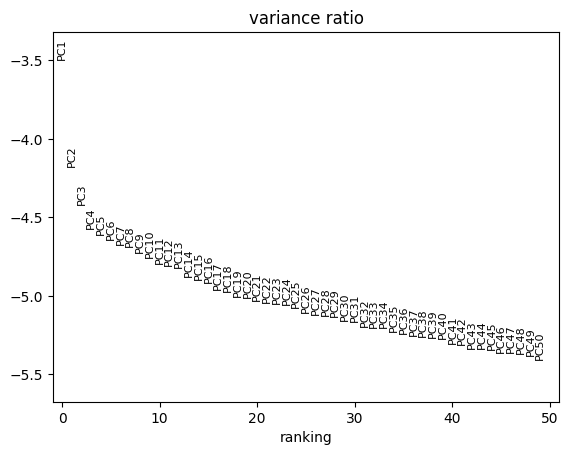

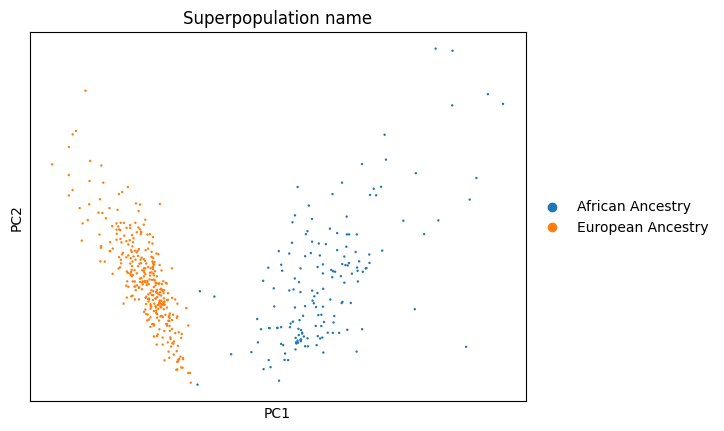

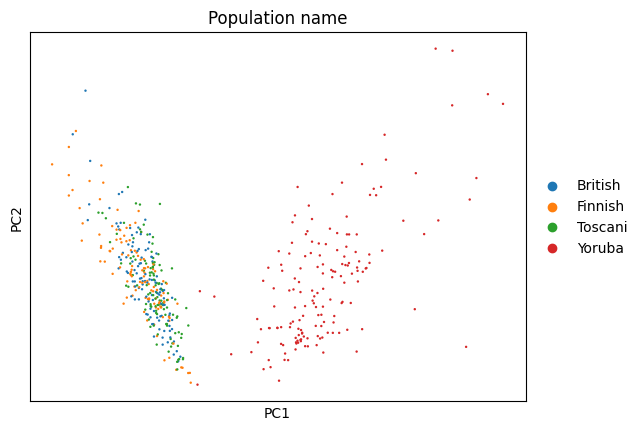

In [19]:
plot_pca(adata_vcrs_without_CEPH, min_samples_per_variant=min_samples_per_variant, log_adata=True, n_top_variants=n_top_variants, batch_key=None, do_scaling=True, n_pcs=50, size=12, remove_outliers=True)

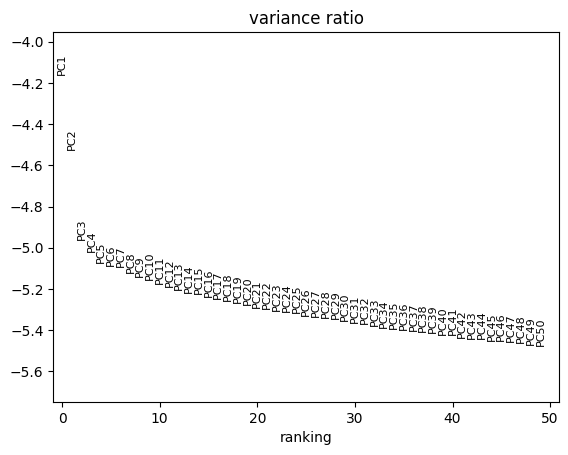

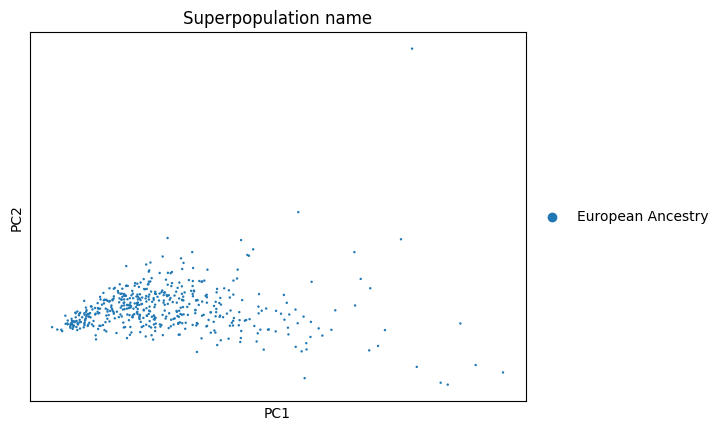

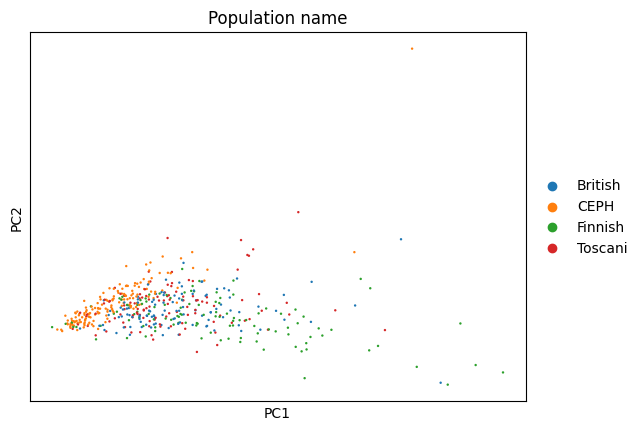

In [20]:
plot_pca(adata_vcrs_without_African, min_samples_per_variant=min_samples_per_variant, log_adata=True, n_top_variants=n_top_variants, batch_key=None, do_scaling=True, n_pcs=50, size=12)

### Binarize

Binary matrix means do not log1p or scale


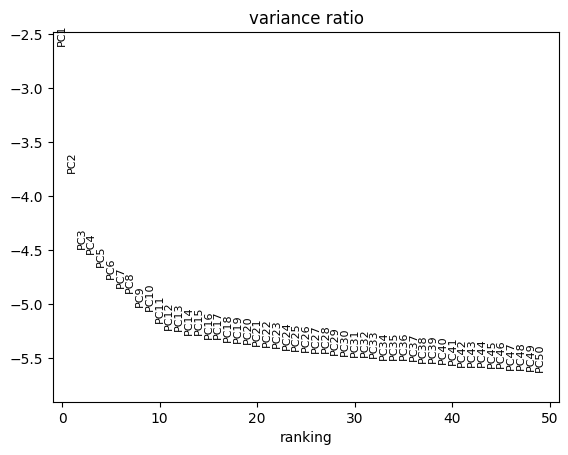

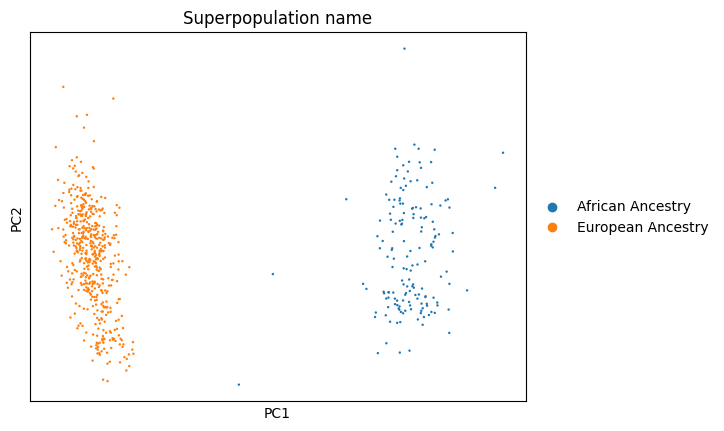

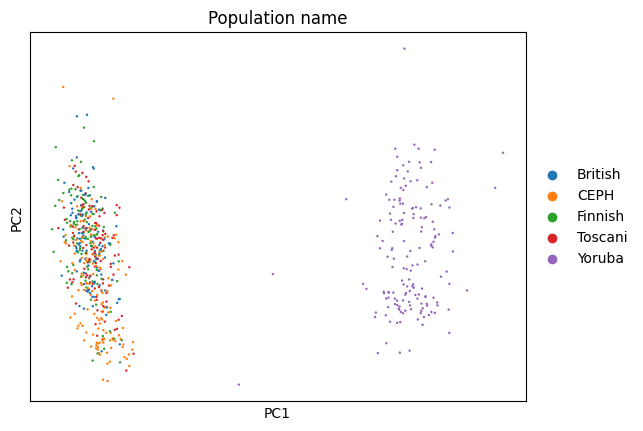

In [21]:
plot_pca(adata_vcrs, min_samples_per_variant=min_samples_per_variant, log_adata=False, n_top_variants=n_top_variants, batch_key=None, do_scaling=False, n_pcs=50, size=12, use_binary_matrix=True, mean_scaling=True)

### Compare to genotype

In [22]:
adata_genotype_without_CEPH = adata_genotype[adata_genotype.obs['Population name'] != 'CEPH'].copy()
adata_genotype_without_African = adata_genotype[adata_genotype.obs['Superpopulation name'] != 'African Ancestry'].copy()

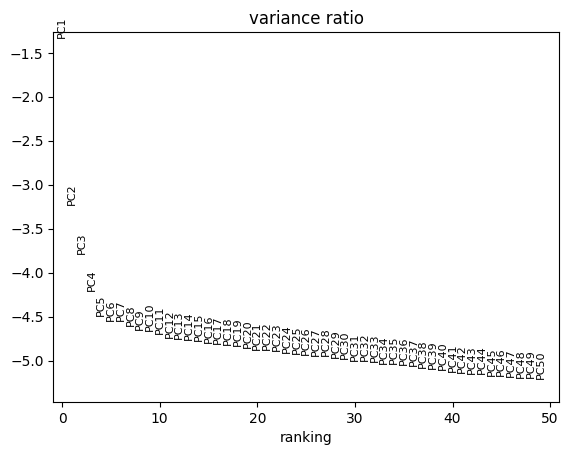

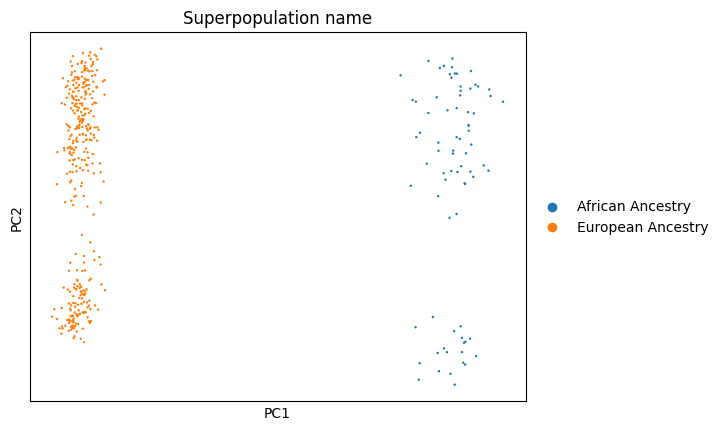

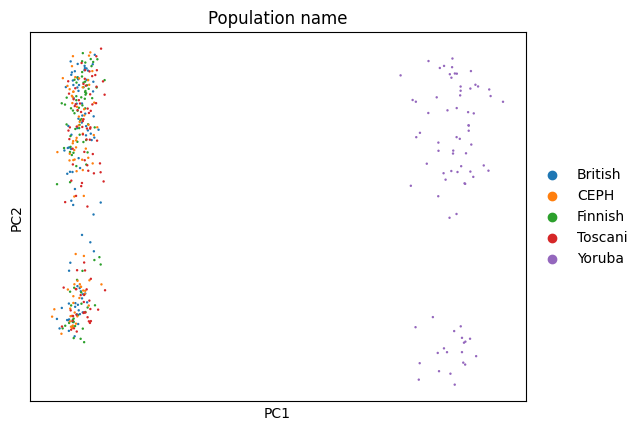

In [28]:
plot_pca(adata_genotype, min_samples_per_variant=min_samples_per_variant, log_adata=False, n_top_variants=n_top_variants, batch_key=None, do_scaling=False, mean_scaling=True, n_pcs=50, size=12)

/home/jmrich/miniconda3/envs/varseek2/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:306: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


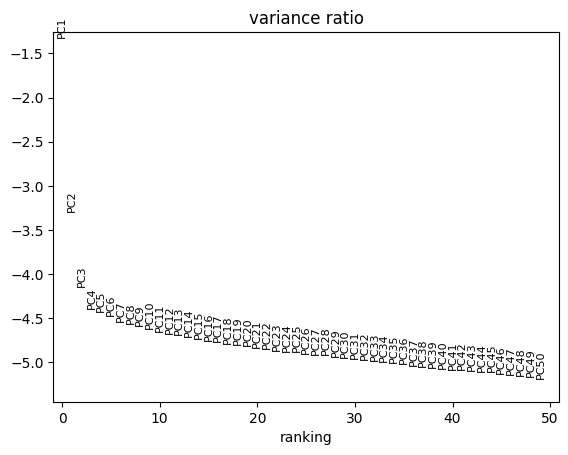

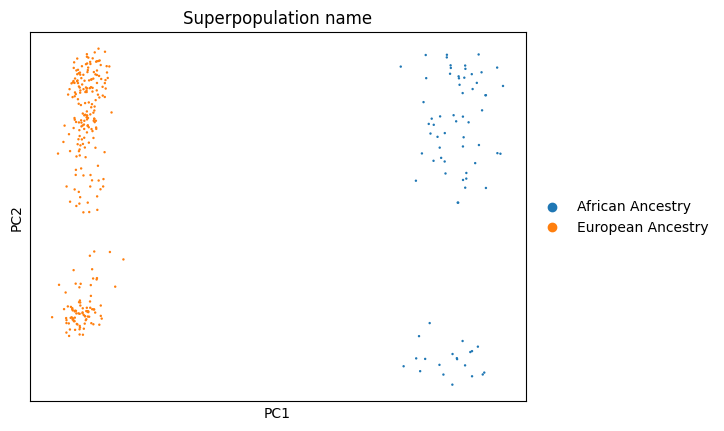

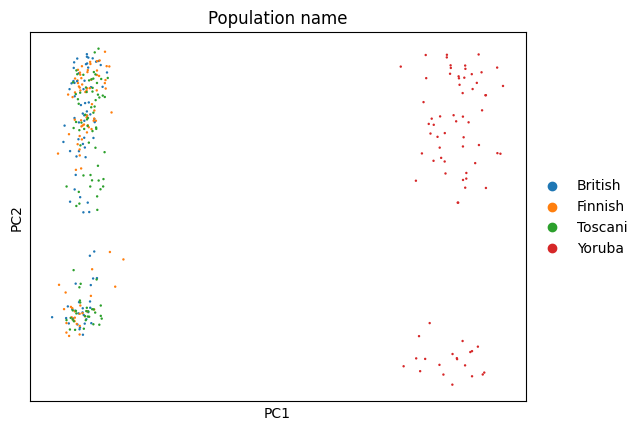

In [29]:
plot_pca(adata_genotype_without_CEPH, min_samples_per_variant=min_samples_per_variant, log_adata=False, n_top_variants=n_top_variants, batch_key=None, do_scaling=False, mean_scaling=True, n_pcs=50, size=12)

/home/jmrich/miniconda3/envs/varseek2/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:306: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


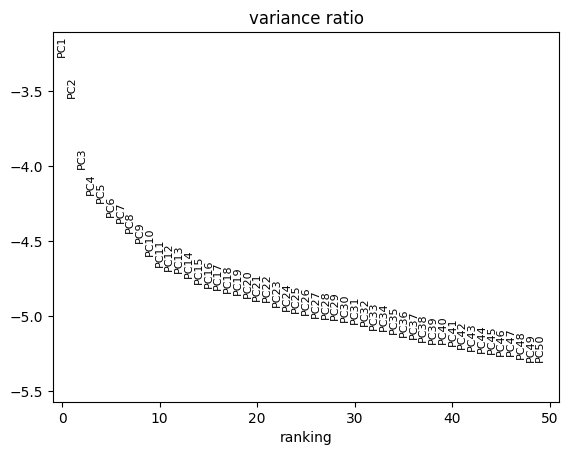

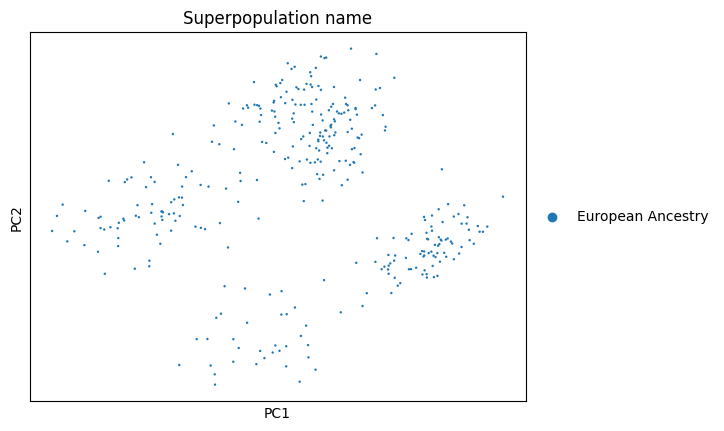

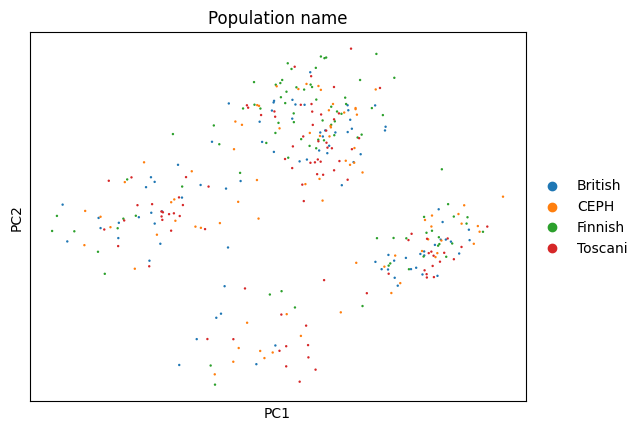

In [30]:
plot_pca(adata_genotype_without_African, min_samples_per_variant=min_samples_per_variant, log_adata=False, n_top_variants=n_top_variants, batch_key=None, do_scaling=False, mean_scaling=True, n_pcs=50, size=12)

In [31]:
# if do_scaling:
#     adata_vcrs.raw.to_adata()